In [871]:
import numpy as np
import matplotlib.pyplot as plt

In [872]:
def service(N, K):
    #This is a binomial probability distribution with N trials and K successes
    #The probability of success is k/N
    return np.random.binomial(N, K/N)
def arrival_bernoulli(p):
    #This is a Bernoulli distribution with probability p
    return np.random.choice([0,1], p=[1-p, p])
    

In [873]:
def average_delay_update(i, R, Tn, Dnplusone, n):
    #This is the update equation for the average delay
    #Tn is the previous average delay
    #Dnplusone is the new delay
    if(Tn == 0):
        return Dnplusone
    if(i<R):
        return (Tn*n+Dnplusone)/(n+1)
    return 0.9*Tn + 0.1*Dnplusone

In [874]:
def arrival_general_update(i, p, n, t, T, R, arrival_times, service_times, delta):
    #This is the update equation for the probability of arrival
    #p is the previous probability of arrival
    #n is the number of packets served so far for this flow
    #T is the average delay for this flow
    #arrival_times is the list of arrival times for this flow
    #service_times is the list of service times for this flow
    #This function returns the new probability of arrival
    if n == 0:
        return p
    elif i<R:
        return p
    elif len(arrival_times) > len(service_times):
        if(arrival_times[len(service_times)] <= t - np.ceil(1.2*T)):
            return 2*p/3
    #for the 2nd case,
    #the first packet served in this time slot should have arrived 
    #at most 1.2*T time slots ago
    else:
        for i in range(len(service_times)):
            if service_times[i] == t:
                if arrival_times[i] > t - np.ceil(1.2*T):
                    return min(0.9, p+delta)
                else:
                    break
    return p

In [875]:
N=150
K=50
R=40
T = 1000
p=0.5
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

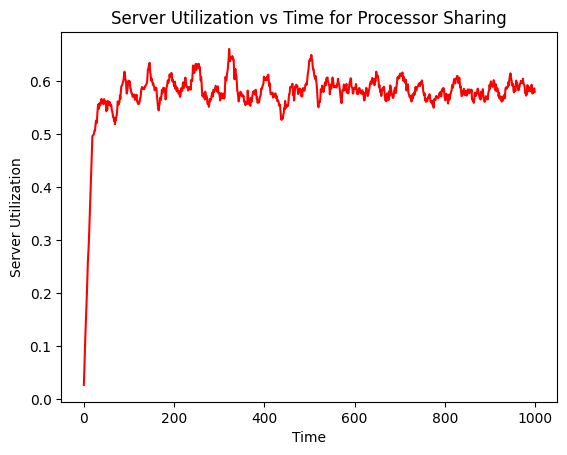

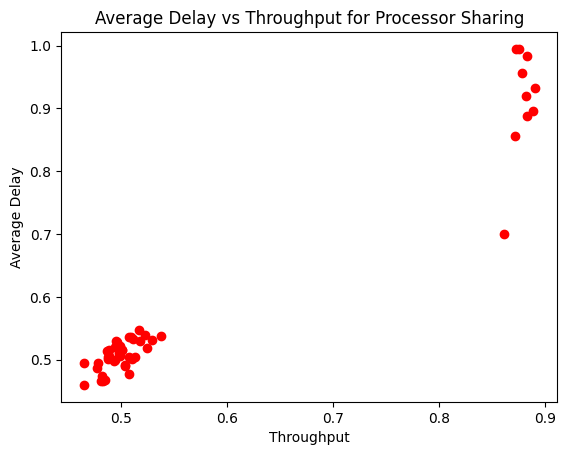

In [876]:
#Scheme 1: Processor Sharing
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            arrival_times[i].append(t)
            queue_size[i] += 1
    #total service capacity
    S = service(N, K)
    S_copy = S
    #finding 'l' value as per the scheme:
    for l in range(0,100):
        if(S > l*K and S <= (l+1)*K):
            break

    #servicing
    #serve l packets from each flow first, then serve one additional packet
    #from each flow in a round robin fashion until S packets are served
    for i in range(K):
        for j in range(l):
            if(queue_size[i] > 0):
                service_times[i].append(t)
                queue_size[i] -= 1
                number_of_packets_served[i][t] += 1
                S -= 1
    #round robin
    i=0
    while(S > 0):
        if(queue_size[i] > 0):
            service_times[i].append(t)
            queue_size[i] -= 1
            number_of_packets_served[i][t] += 1
            S -= 1
        i = (i+1)%K
        if(i == 0):
            break
    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy

    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01)

#plotting moving average of server utilization
moving_average = [0 for i in range(T)]
for i in range(T):
    total = 0
    for j in range(20):
        if(i-j >= 0):
            total = total + server_utilization[i-j]
    moving_average[i] = total/20
plt.plot(moving_average, 'r')
plt.xlabel('Time')
plt.ylabel('Server Utilization')
plt.title('Server Utilization vs Time for Processor Sharing')
plt.show()



#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T

#plotting throughput and average delay for each flow
plt.plot(throughput, average_delay, 'ro')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Average Delay vs Throughput for Processor Sharing')
plt.show()

throughput_processor_sharing = throughput
average_delay_processor_sharing = average_delay
server_utilization_processor_sharing = server_utilization
moving_average_processor_sharing = moving_average

In [877]:
#Re-running initialiser code to reset all values
N=150
K=50
R=40
T = 1000
p=0.5
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

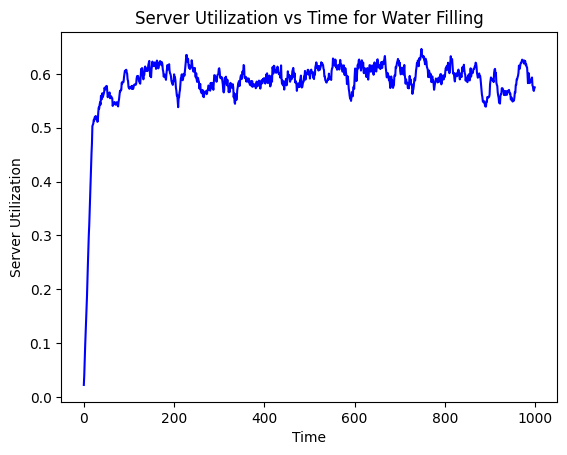

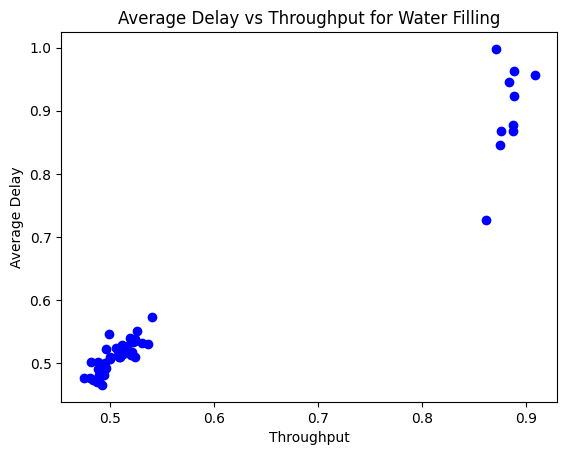

In [878]:
#Scheme 2: Water filling or minimising the max queue
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            arrival_times[i].append(t)
            queue_size[i] += 1
    #total service capacity
    S = service(N, K)
    S_copy = S

    #servicing
    #at each time slot, serve the flow with the maximum queue size
    while(S>0):
        #finding the flow with the maximum queue size
        max_queue = 0
        for j in range(K):
            if(queue_size[j] > max_queue):
                max_queue = queue_size[j]
                max_flow = j
        #serving the flow with the maximum queue size
        if(max_queue == 0):
            break
        service_times[max_flow].append(t)
        queue_size[max_flow] -= 1
        number_of_packets_served[max_flow][t] += 1
        S -= 1

    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy

    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01)

#plotting moving average of server utilization
moving_average = [0 for i in range(T)]
for i in range(T):
    total = 0
    for j in range(20):
        if(i-j >= 0):
            total = total + server_utilization[i-j]
    moving_average[i] = total/20
plt.plot(moving_average, 'b')
plt.xlabel('Time')
plt.ylabel('Server Utilization')
plt.title('Server Utilization vs Time for Water Filling')
plt.show()

#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T

#plotting throughput and average delay for each flow
plt.plot(throughput, average_delay, 'bo')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Average Delay vs Throughput for Water Filling')
plt.show()

throughput_water_filling = throughput
average_delay_water_filling = average_delay
server_utilization_water_filling = server_utilization
moving_average_water_filling = moving_average


In [879]:
#Re-running initialiser code to reset all values
N=150
K=50
R=40
T = 1000
p=0.5
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

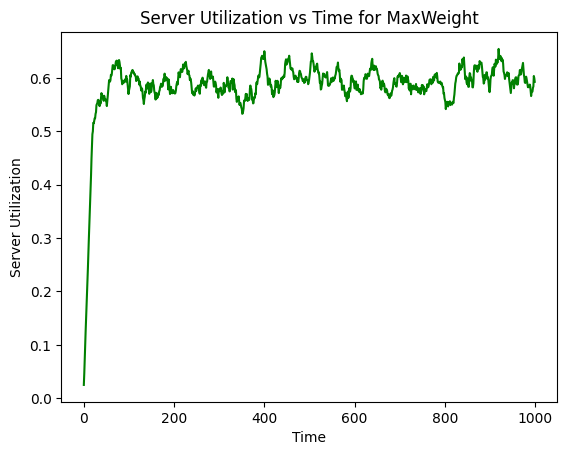

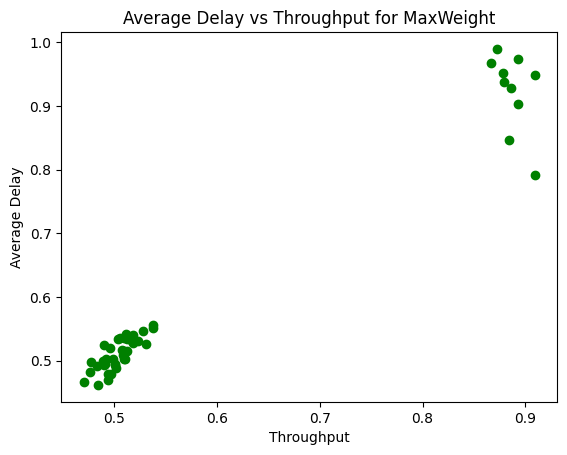

In [880]:
#Scheme 3: MaxWeight
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            arrival_times[i].append(t)
            queue_size[i] += 1
    #total service capacity
    S = service(N, K)
    S_copy = S

    #servicing
    #at each time slot, give all S slots to the flow with the maximum weight (queue size)
    while(S>0):
        #finding the flow with the maximum queue size
        max_queue = 0
        for j in range(K):
            if(queue_size[j] > max_queue):
                max_queue = queue_size[j]
                max_flow = j
        if(max_queue == 0):
            break
        for i in range(max_queue):
            if(S == 0):
                break
            service_times[max_flow].append(t)
            queue_size[max_flow] -= 1
            number_of_packets_served[max_flow][t] += 1
            S -= 1
    
    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy
    
    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01)

#plotting moving average of server utilization
moving_average = [0 for i in range(T)]
for i in range(T):
    total = 0
    for j in range(20):
        if(i-j >= 0):
            total = total + server_utilization[i-j]
    moving_average[i] = total/20
plt.plot(moving_average, 'g')
plt.xlabel('Time')
plt.ylabel('Server Utilization')
plt.title('Server Utilization vs Time for MaxWeight')
plt.show()   

#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T

#plotting throughput and average delay for each flow
plt.plot(throughput, average_delay, 'go')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Average Delay vs Throughput for MaxWeight')
plt.show()

throughput_max_weight = throughput
average_delay_max_weight = average_delay
server_utilization_max_weight = server_utilization
moving_average_max_weight = moving_average


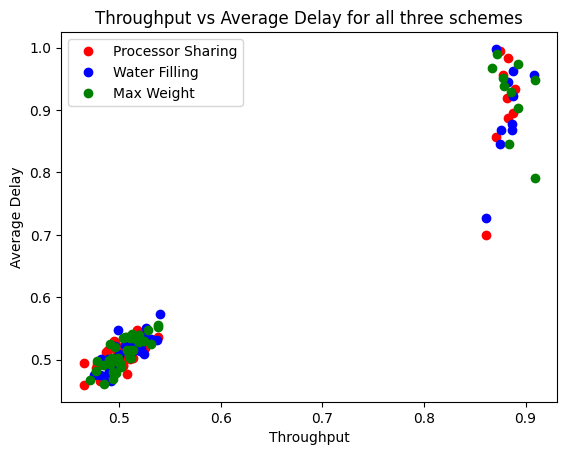

In [881]:
#Plotting throughputs of all three schemes on the same graph
plt.plot(throughput_processor_sharing, average_delay_processor_sharing, 'ro', label = 'Processor Sharing')
plt.plot(throughput_water_filling, average_delay_water_filling, 'bo', label = 'Water Filling')
plt.plot(throughput_max_weight, average_delay_max_weight, 'go', label = 'Max Weight')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for all three schemes')
plt.legend()
plt.show()


Throughput for flow 4 for Processor Sharing Scheme: 0.51
Average Delay for flow 4 for Processor Sharing Scheme: 0.5004312799936225
Throughput for flow 4 for Water Filling Scheme: 0.482
Average Delay for flow 4 for Water Filling Scheme: 0.501839462489364
Throughput for flow 4 for Max Weight Scheme: 0.519
Average Delay for flow 4 for Max Weight Scheme: 0.5396742164579452


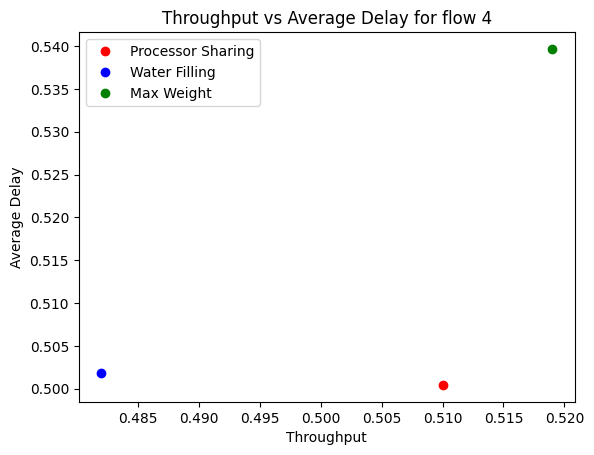

In [882]:
#Comparing throughput and average delay for all three schemes for a particular flow
pipe = 4
print("Throughput for flow", pipe, "for Processor Sharing Scheme:", throughput_processor_sharing[pipe-1])
print("Average Delay for flow", pipe, "for Processor Sharing Scheme:", average_delay_processor_sharing[pipe-1])
print("Throughput for flow", pipe, "for Water Filling Scheme:", throughput_water_filling[pipe-1])
print("Average Delay for flow", pipe, "for Water Filling Scheme:", average_delay_water_filling[pipe-1])
print("Throughput for flow", pipe, "for Max Weight Scheme:", throughput_max_weight[pipe-1])
print("Average Delay for flow", pipe, "for Max Weight Scheme:", average_delay_max_weight[pipe-1])

#Plotting throughput vs average delay for all three schemes for a particular flow
plt.plot(throughput_processor_sharing[pipe-1], average_delay_processor_sharing[pipe-1], 'ro', label = 'Processor Sharing')
plt.plot(throughput_water_filling[pipe-1], average_delay_water_filling[pipe-1], 'bo', label = 'Water Filling')
plt.plot(throughput_max_weight[pipe-1], average_delay_max_weight[pipe-1], 'go', label = 'Max Weight')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for flow ' + str(pipe))
plt.legend()
plt.show()


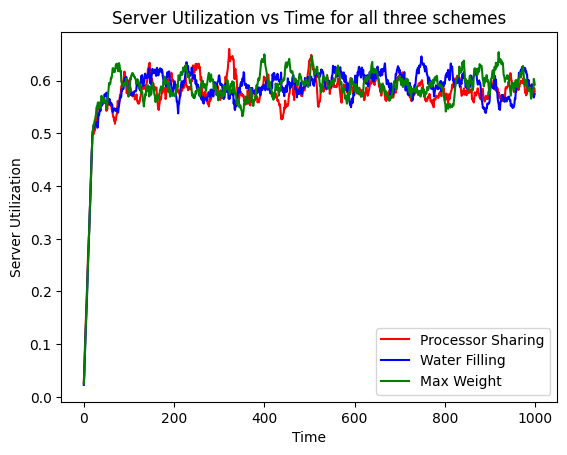

Average server utilization for Processor Sharing Scheme in percentage: 58.13496916247877
Average server utilization for Water Filling Scheme in percentage: 58.98833294687235
Average server utilization for Max Weight Scheme in percentage: 59.14661031139213


In [883]:
#Plotting server utilizations of all three schemes on the same graph
plt.plot(moving_average_processor_sharing, 'r', label = 'Processor Sharing')
plt.plot(moving_average_water_filling, 'b', label = 'Water Filling')
plt.plot(moving_average_max_weight, 'g', label = 'Max Weight')
plt.xlabel('Time')
plt.ylabel('Server Utilization')
plt.title('Server Utilization vs Time for all three schemes')
plt.legend()
plt.show()
#comparing average server utilization for all three schemes in percentage
print("Average server utilization for Processor Sharing Scheme in percentage:", np.mean(server_utilization_processor_sharing)*100)
print("Average server utilization for Water Filling Scheme in percentage:", np.mean(server_utilization_water_filling)*100)
print("Average server utilization for Max Weight Scheme in percentage:", np.mean(server_utilization_max_weight)*100)
